In [10]:
# data
import nfl_data_py as nfl

# data loading and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.linear_model import LinearRegression

# interpretation
import shap
from interpret import show
from scipy.stats import spearmanr

# pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, nan_euclidean_distances

pd.set_option('display.max_columns', None)  # None zeigt alle Spalten
pd.set_option('display.max_rows', None)  # Alle Zeilen anzeigen, vorsichtig bei großen DataFrames
pd.set_option('display.width', 1000)  # Breite anpassen


In [11]:
# Positionsspezifische Stats zusammengefasst (passing, rushing und receiving zu total_features zusammengefasst)
# Alle Metriken (ewm, mean, median, min, max, std)
# --> performed soweit am besten

def load_and_merge_data():
    df_ids = nfl.import_ids()
    df_weekly = nfl.import_weekly_data(list(range(2018, 2025)))
    df_seasonal = nfl.import_seasonal_data(list(range(2017,2024)))
    df_schedule = nfl.import_schedules(list(range(2018, 2025)))
    df_pass_pfr = nfl.import_weekly_pfr('pass', list(range(2018, 2025)))
    df_rush_pfr = nfl.import_weekly_pfr('rush', list(range(2018, 2025)))
    df_rec_pfr = nfl.import_weekly_pfr('rec', list(range(2018, 2025)))
    df_pass_ngs = nfl.import_ngs_data('passing',list(range(2018, 2025)))
    df_rush_ngs = nfl.import_ngs_data('rushing',list(range(2018, 2025)))
    df_snap_counts = nfl.import_snap_counts(list(range(2018, 2025)))

    df_weekly = df_weekly[(df_weekly['season_type'] == 'REG') & (df_weekly['position'].isin(['QB', 'WR', 'RB', 'TE']))].reset_index()

    df_seasonal['season'] = df_seasonal['season'] + 1

    df_schedule = df_schedule[['game_id', 'home_team', 'home_score', 'away_score']].drop_duplicates()
    df_schedule['game_id'] = df_schedule['game_id'].str.replace('OAK', 'LV', regex=False) # Umzug der Oakland Raiders nach Las Vegas in der Saison 2020
    df_schedule['home_team'] = df_schedule['home_team'].str.replace('OAK', 'LV', regex=False) # Umzug der Oakland Raiders nach Las Vegas in der Saison 2020

    df_weekly['game_id_home_away'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['recent_team']+'_'+df_weekly['opponent_team']
    df_weekly['game_id_away_home'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['opponent_team']+'_'+df_weekly['recent_team']

    df_merged = pd.melt(
        df_weekly,
        id_vars=['player_id', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_2pt_conversions', 'interceptions', 'sack_fumbles_lost', 'sacks', 'sack_yards', 'passing_air_yards', 'passing_epa', 'pacr', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 'rushing_fumbles_lost', 'rushing_epa', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'racr', 'wopr', 'receiving_epa', 'fantasy_points'],
        value_vars=['game_id_home_away', 'game_id_away_home'],
        var_name='game_id_type',
        value_name='game_id'
    )

    df_ids = df_ids.rename(columns={'gsis_id': 'player_id', 'pfr_id': 'pfr_player_id'})
    df_pass_ngs = df_pass_ngs.rename(columns={'player_gsis_id': 'player_id'})
    df_rush_ngs = df_rush_ngs.rename(columns={'player_gsis_id': 'player_id'})

    df_merged = pd.merge(df_merged, df_schedule, on='game_id', how='inner') # Bei ein paar Spielen: recent_team = opponent_team
    df_merged = pd.merge(df_merged, df_ids[['player_id', 'pfr_player_id', 'draft_pick', 'draft_year']], on = 'player_id', how = 'inner') # Ein paar Spieler ohne draft_year
    df_merged = pd.merge(df_merged, df_seasonal[['player_id', 'season', 'dom']], on = ['player_id', 'season'], how = 'left')
    df_merged = pd.merge(df_merged, df_pass_pfr[['pfr_player_id', 'season', 'week', 'passing_bad_throws', 'times_pressured']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_rec_pfr[['pfr_player_id', 'season', 'week', 'receiving_rat']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_rush_pfr[['pfr_player_id', 'season', 'week', 'rushing_broken_tackles']], on = ['pfr_player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_pass_ngs[['player_id', 'season', 'week', 'passer_rating', 'aggressiveness']], on = ['player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_rush_ngs[['player_id', 'season', 'week', 'efficiency']], on = ['player_id', 'season', 'week'], how = 'left')
    df_merged = pd.merge(df_merged, df_snap_counts[['pfr_player_id', 'season', 'week', 'offense_snaps']], on = ['pfr_player_id', 'season', 'week'], how = 'left')

    df_merged = df_merged.drop(columns=['game_id_type', 'pfr_player_id'])
    return df_merged



def edit_data(df_merged):
    df_merged['draft_pick'] = df_merged['draft_pick'].fillna(260)
    df_merged = df_merged.fillna(0)

    df_merged['rookie_flag'] = (df_merged['season'] == df_merged['draft_year']).astype(int)
    df_merged['last_season_data_flag'] = (df_merged['week'] < 6).astype(int)
    df_merged['home'] = (df_merged['home_team'] == df_merged['recent_team']).astype(int)
    df_merged['player_id'] = df_merged['player_id'].str.replace('00-00', '').astype(int)

    # interceptions und fumbles als eigene features statt als turnover aggregiert
    df_merged['turnover'] = (
        df_merged['interceptions'] +
        df_merged['sack_fumbles_lost'] +
        df_merged['rushing_fumbles_lost'] +
        df_merged['receiving_fumbles_lost']
    )

    # total epa aggregiert statt passing, rushing und receiving einzeln
    df_merged['epa_total'] = (
        df_merged['passing_epa'] + 
        df_merged['rushing_epa'] + 
        df_merged['receiving_epa']
    )

    # total points aggregiert statt passing, rushing und receiving tds und 2pt conversions einzeln
    df_merged['points_total'] = (
        (df_merged['rushing_tds'] * 6) + 
        (df_merged['rushing_2pt_conversions'] * 2) + 
        (df_merged['receiving_tds'] * 6) + 
        (df_merged['receiving_2pt_conversions'] * 2) + 
        (df_merged['passing_tds'] * 6) + 
        (df_merged['passing_2pt_conversions'] * 2)
    )

    # total yards aggregiert statt passing, rushing und receiving einzeln
    df_merged['yards_total'] = (
        df_merged['passing_yards'] +
        df_merged['rushing_yards'] +
        df_merged['receiving_yards']
    )

    # position target-encoded
    position_means = df_merged.groupby(['position', 'season', 'week'])['fantasy_points'].mean().reset_index()
    position_means.rename(columns={'fantasy_points': 'position_encoded'}, inplace=True)
    df_merged = pd.merge(df_merged, position_means, on=['position', 'season', 'week'], how='left')

    return df_merged



def create_rolling_features(df_merged):  

    # points_scored und points_allowed als Maßstab für Stärke eines Teams
    df_merged['recent_team_points_scored'] = df_merged.apply(lambda row: row['home_score'] if row['home'] == 1 else row['away_score'], axis=1)
    df_merged['opponent_team_points_allowed'] = df_merged['recent_team_points_scored']

    df_unique_opponent_team_points_allowed = df_merged.drop_duplicates(subset=['game_id', 'opponent_team', 'opponent_team_points_allowed'])
    df_unique_recent_team_points_scored = df_merged.drop_duplicates(subset=['game_id', 'recent_team', 'recent_team_points_scored'])

    df_unique_opponent_team_points_allowed = df_unique_opponent_team_points_allowed.sort_values(by=['opponent_team', 'season', 'week']).reset_index(drop=True)
    df_unique_recent_team_points_scored = df_unique_recent_team_points_scored.sort_values(by=['recent_team', 'season', 'week']).reset_index(drop=True)

    df_unique_opponent_team_points_allowed['ewm_opponent_team_points_allowed_l5w'] = (
        df_unique_opponent_team_points_allowed.groupby('opponent_team')['opponent_team_points_allowed']
        .apply(lambda x: x.shift(1).ewm(span=5, min_periods=5).mean())
        .reset_index(level=0, drop=True)
    )

    for metric in ['mean', 'median', 'std']:
            df_unique_opponent_team_points_allowed[f"{metric}_opponent_team_points_allowed_l5w"] = (
                df_unique_opponent_team_points_allowed.groupby('opponent_team')['opponent_team_points_allowed']
                .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).agg(metric))  # shift(1) schließt aktuelle Woche aus
                .reset_index(level=0, drop=True)  # Index zurücksetzen
        )

    for metric in ['min', 'max']:
            df_unique_opponent_team_points_allowed[f"{metric}_opponent_team_points_allowed_l3w"] = (
                df_unique_opponent_team_points_allowed.groupby('opponent_team')['opponent_team_points_allowed']
                .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).agg(metric))  # shift(1) schließt aktuelle Woche aus
                .reset_index(level=0, drop=True)  # Index zurücksetzen
        )

    df_unique_opponent_team_points_allowed = df_unique_opponent_team_points_allowed.drop(columns=['player_id', 'draft_year', 'turnover', 'interceptions', 'sack_fumbles_lost', 'rushing_fumbles_lost', 'receiving_fumbles_lost', 'points_total', 'rushing_tds', 'rushing_2pt_conversions', 'receiving_tds', 'receiving_2pt_conversions', 'passing_tds', 'passing_2pt_conversions', 'epa_total', 'passing_epa', 'rushing_epa', 'receiving_epa', 'position', 'season', 'week', 'recent_team', 'home_team', 'completions', 'attempts', 'passing_yards', 'sacks', 'sack_yards', 'passing_air_yards', 'pacr', 'carries', 'rushing_yards', 'receptions', 'targets', 'yards_total', 'receiving_yards', 'racr', 'wopr', 'fantasy_points', 'home_score', 'away_score', 'draft_pick', 'dom', 'passing_bad_throws', 'times_pressured', 'receiving_rat', 'rushing_broken_tackles', 'passer_rating', 'aggressiveness', 'efficiency', 'offense_snaps', 'rookie_flag', 'last_season_data_flag', 'home', 'position_encoded', 'recent_team_points_scored', 'opponent_team_points_allowed'])
    df_merged = pd.merge(df_merged, df_unique_opponent_team_points_allowed, on=['game_id','opponent_team'], how='inner')

    df_unique_recent_team_points_scored['ewm_recent_team_points_scored_l5w'] = (
        df_unique_recent_team_points_scored.groupby('recent_team')['recent_team_points_scored']
        .apply(lambda x: x.shift(1).ewm(span=5, min_periods=5).mean())
        .reset_index(level=0, drop=True)
    )

    for metric in ['mean', 'median', 'std']:
            df_unique_recent_team_points_scored[f"{metric}_recent_team_points_scored_l5w"] = (
                df_unique_recent_team_points_scored.groupby('recent_team')['recent_team_points_scored']
                .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).agg(metric))  # shift(1) schließt aktuelle Woche aus
                .reset_index(level=0, drop=True)  # Index zurücksetzen
        )

    for metric in ['min', 'max']:
            df_unique_recent_team_points_scored[f"{metric}_recent_team_points_scored_l3w"] = (
                df_unique_recent_team_points_scored.groupby('recent_team')['recent_team_points_scored']
                .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).agg(metric))  # shift(1) schließt aktuelle Woche aus
                .reset_index(level=0, drop=True)  # Index zurücksetzen
        )

    df_unique_recent_team_points_scored = df_unique_recent_team_points_scored.drop(columns=['player_id', 'draft_year', 'turnover', 'interceptions', 'sack_fumbles_lost', 'rushing_fumbles_lost', 'receiving_fumbles_lost', 'points_total', 'rushing_tds', 'rushing_2pt_conversions', 'receiving_tds', 'receiving_2pt_conversions', 'passing_tds', 'passing_2pt_conversions', 'epa_total', 'passing_epa', 'rushing_epa', 'receiving_epa', 'position', 'season', 'week', 'opponent_team', 'home_team', 'completions', 'attempts', 'yards_total', 'passing_yards', 'sacks', 'sack_yards', 'passing_air_yards', 'pacr', 'carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'racr', 'wopr', 'fantasy_points', 'home_score', 'away_score', 'draft_pick', 'dom', 'passing_bad_throws', 'times_pressured', 'receiving_rat', 'rushing_broken_tackles', 'passer_rating', 'aggressiveness', 'efficiency', 'offense_snaps', 'rookie_flag', 'last_season_data_flag', 'home', 'position_encoded', 'recent_team_points_scored', 'opponent_team_points_allowed'])
    df_merged = pd.merge(df_merged, df_unique_recent_team_points_scored, on=['game_id','recent_team'], how='inner')

    # Liste der Spalten mit Spielerspezifischen numerischen Daten, für die Rolling-Features erstellt werden sollen
    columns_to_roll = ['completions', 'attempts', 'sacks', 'passer_rating', 'aggressiveness', 'efficiency', 'sack_yards', 
                    'passing_air_yards', 'pacr', 'carries', 'offense_snaps', 'yards_total', 'receptions', 'targets',
                    'racr', 'wopr', 'fantasy_points', 'passing_bad_throws', 'times_pressured', 'position_encoded', 'receiving_rat', 
                    'rushing_broken_tackles', 'turnover', 'points_total', 'epa_total']


    # Sortiere nach player_id, season und week
    df_merged = df_merged.sort_values(by=['player_id', 'season', 'week']).reset_index(drop=True)


    df_merged['cnt_games_over_20ffpts_l5w'] = (
        df_merged.groupby('player_id')['fantasy_points']
        .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).apply(lambda y: (y > 20).sum()))
        .reset_index(level=0, drop=True)
    )

    # Rolling-Features erstellen
    for col in columns_to_roll:

        feature_name_1 = f"ewm_{col}_l5w"
        df_merged[feature_name_1] = (
            df_merged.groupby('player_id')[col]
            .apply(lambda x: x.shift(1).ewm(span=5, min_periods=5).mean())
            .reset_index(level=0, drop=True)
        )

        for metric in ['mean', 'median', 'std']:
            feature_name_2 = f"{metric}_{col}_l5w"
            rolling_result_5w = (
                df_merged.groupby('player_id')[col]
                    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=5).agg(metric))  # shift(1) schließt aktuelle Woche aus
                    .reset_index(level=0, drop=True)  # Index zurücksetzen
            )
            # Einfügen der Rolling-Metrik
            df_merged[feature_name_2] = rolling_result_5w

        for metric in ['max', 'min']:
            feature_name_3 = f"{metric}_{col}_l3w"
            # Berechnung der Rolling-Metrik (ohne aktuelle Woche)
            rolling_result_3w = (
                df_merged.groupby('player_id')[col]
                    .apply(lambda x: x.shift(1).rolling(window=3, min_periods=3).agg(metric))  # shift(1) schließt aktuelle Woche aus
                    .reset_index(level=0, drop=True)  # Index zurücksetzen
            )
            # Einfügen der Rolling-Metrik
            df_merged[feature_name_3] = rolling_result_3w

    df_merged = df_merged.drop(columns=['completions', 'attempts', 'passing_yards', 'sacks', 'sack_yards', 'passing_air_yards', 'pacr', 'carries', 
                                        'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'racr', 'wopr', 'passing_bad_throws', 
                                        'times_pressured', 'receiving_rat', 'rushing_broken_tackles', 'draft_year', 'home_team', 
                                        'passer_rating', 'aggressiveness', 'efficiency', 'offense_snaps', 'game_id',  'interceptions', 'sack_fumbles_lost', 
                                        'rushing_fumbles_lost', 'receiving_fumbles_lost', 'rushing_tds', 'rushing_2pt_conversions', 'receiving_tds', 
                                        'receiving_2pt_conversions', 'passing_tds', 'passing_2pt_conversions', 'passing_epa', 'rushing_epa', 'receiving_epa',
                                        'position_encoded', 'recent_team', 'opponent_team', 'position', 'home_score', 'away_score',
                                        'recent_team_points_scored', 'opponent_team_points_allowed', 'turnover', 'points_total', 'yards_total',
                                        'epa_total'])

    df_merged = df_merged.dropna().reset_index(level=0, drop=True)

    return df_merged



def prepare_features():  

    df_merged = load_and_merge_data()
    df_merged = edit_data(df_merged)
    df_merged = create_rolling_features(df_merged)

    return df_merged


In [12]:
def split_data(df_merged):

    X_train = df_merged[df_merged['season'].isin(list(range(2018, 2024)))].drop(columns=['fantasy_points'])
    y_train = df_merged[df_merged['season'].isin(list(range(2018, 2024)))]['fantasy_points']

    X_val = df_merged[df_merged['season']==2023].drop(columns=['fantasy_points'])
    y_val = df_merged[df_merged['season']==2023]['fantasy_points']

    X_test = df_merged[df_merged['season']==2024].drop(columns=['fantasy_points'])
    y_test = df_merged[df_merged['season']==2024]['fantasy_points']

    return X_train, X_test, y_train, y_test

In [13]:
def create_preprocessor(df_merged):

    X = df_merged.drop(columns=['fantasy_points'])

    numeric_features = X.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor


In [14]:
def create_pipeline(model, preprocessor):

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline

In [15]:
def optimize_hyperparameters(model, param_grid, X_train, y_train, preprocessor):

    pipeline = create_pipeline(model, preprocessor)
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=3), verbose=2)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_}")
    
    return grid_search.best_estimator_

In [16]:
def evaluate_models(model, X_test, y_test):
    metrics = {
        'mean_absolute_error': mean_absolute_error,
        'mean_squared_error': mean_squared_error,
        'root_mean_squared_error': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'r2_score': r2_score,
        'spearman_rank_correlation': lambda y_true, y_pred: spearmanr(y_true, y_pred)[0]
    }

    y_pred = model.predict(X_test)
    model_name = model.named_steps['model'].__class__.__name__
    print(f"Evaluation results for model: {model_name}")
    for metric_name, metric_func in metrics.items():
        score = metric_func(y_test, y_pred)
        print(f"{metric_name}: {score}")
    print("\n")

In [17]:
import shap
from scipy.stats import spearmanr

def plot_feature_importances(model, X_train):
    model_name = model.named_steps['model'].__class__.__name__
    print(f"Plotting feature importances for model: {model_name}")

    # Plot feature importances using SHAP
    explainer = shap.Explainer(model.named_steps['model'], X_train)
    shap_values = explainer(X_train)

    if model_name == 'XGBRegressor':
        # Hole die Feature-Wichtigkeiten
        feature_importances = model.named_steps['model'].feature_importances_
        # Erstelle ein DataFrame für Features und deren Wichtigkeiten
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': feature_importances
        })
        # Sortiere die Feature-Wichtigkeiten absteigend
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        # Wähle die Top 20 Features
        top_features = feature_importance_df.head(20)

        # Plotten der Feature-Wichtigkeiten
        plt.figure(figsize=(10, 8))
        plt.barh(top_features['Feature'], top_features['Importance'])
        plt.gca().invert_yaxis()  # Um die höchste Wichtigkeit oben anzuzeigen
        plt.xlabel("Feature Importance")
        plt.ylabel("Features")
        plt.title(f"Top 20 Feature Importances in {model_name}")
        plt.show()

    # Summary plot
    shap.summary_plot(shap_values, X_train)

    print("\n")

Downcasting floats.


/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_21690/1399416720.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged[feature_name_3] = rolling_result_3w
/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_21690/1399416720.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merged[feature_name_3] = rolling_result_3w
/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_21690/1399416720.py:184: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

Performing Grid Search for XGBoost...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END model__alpha=0.01, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100; total time=   0.2s
[CV] END model__alpha=0.01, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100; total time=   0.3s
[CV] END model__alpha=0.01, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100; total time=   0.4s
[CV] END model__alpha=0.01, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=500; total time=   0.8s
[CV] END model__alpha=0.01, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=500; total time=   1.1s
[CV] END model__alpha=0.01, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=500; total time=   1.2s
[CV] END model__alpha=0.01, model__learning_rate=0.05, model__max_depth=6, model__n_estimators=100; total time=   0.7s
[CV] END model__alpha=0.01, model__learning_rate=0.05, model__max_de

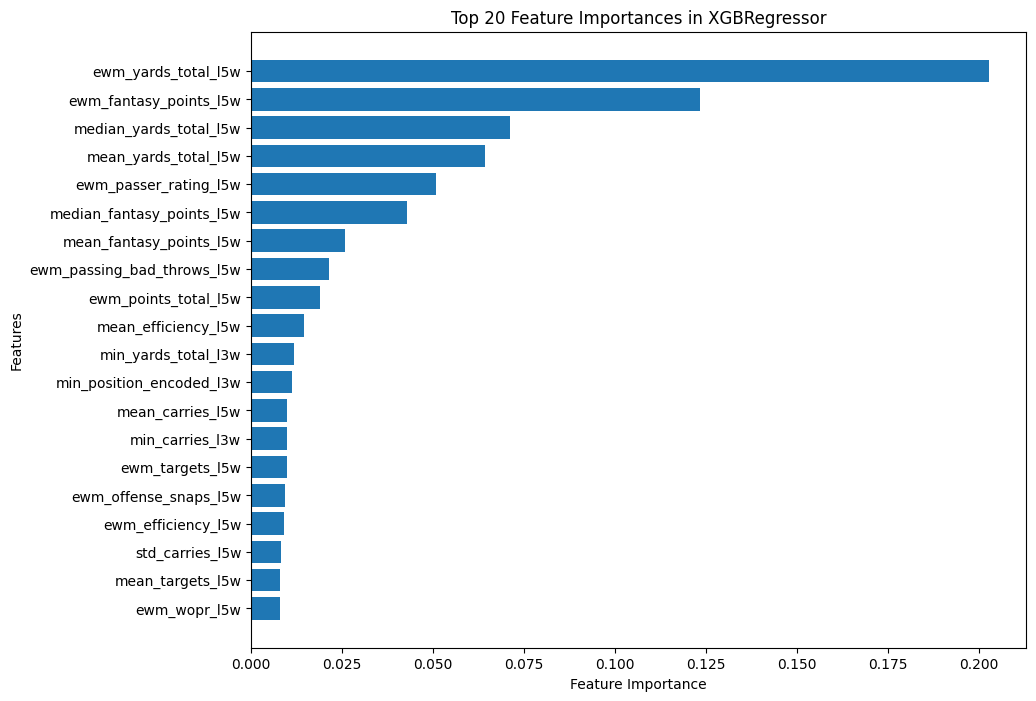

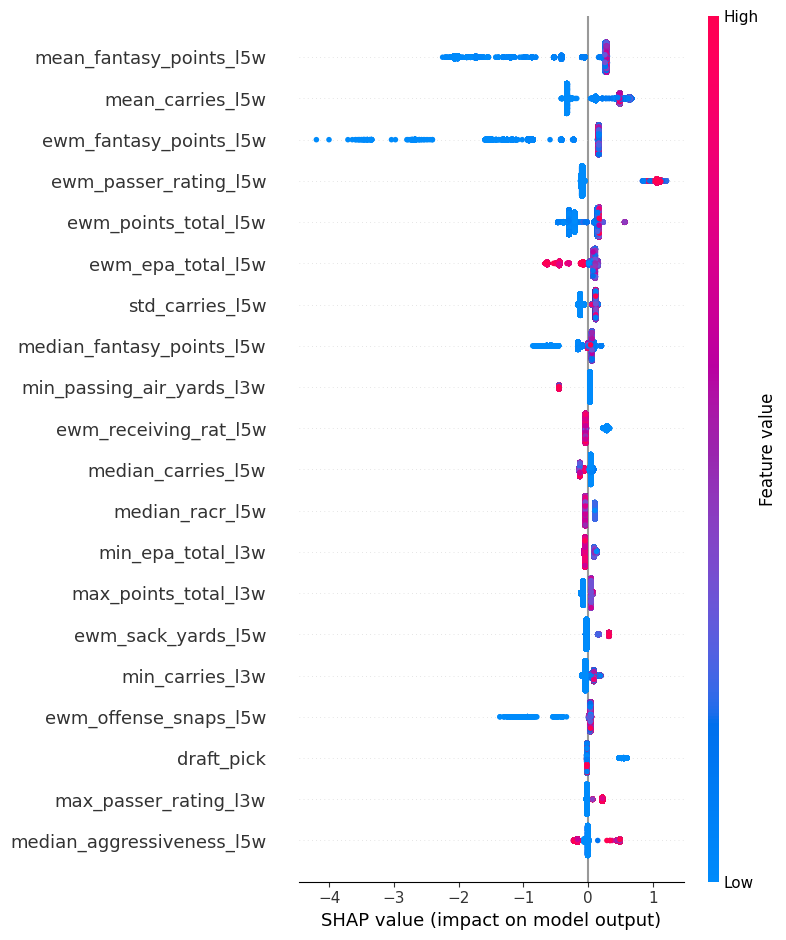



Performing Grid Search for Linear Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .........model__fit_intercept=True, model__n_jobs=1; total time=   0.1s
[CV] END .........model__fit_intercept=True, model__n_jobs=1; total time=   0.3s
[CV] END .........model__fit_intercept=True, model__n_jobs=1; total time=   0.4s
[CV] END ........model__fit_intercept=True, model__n_jobs=-1; total time=   0.3s
[CV] END ........model__fit_intercept=True, model__n_jobs=-1; total time=   0.4s
[CV] END ........model__fit_intercept=True, model__n_jobs=-1; total time=   0.3s
[CV] END ........model__fit_intercept=False, model__n_jobs=1; total time=   0.3s
[CV] END ........model__fit_intercept=False, model__n_jobs=1; total time=   0.4s
[CV] END ........model__fit_intercept=False, model__n_jobs=1; total time=   0.4s
[CV] END .......model__fit_intercept=False, model__n_jobs=-1; total time=   0.3s
[CV] END .......model__fit_intercept=False, model__n_jobs=-1; total time=   0.3s

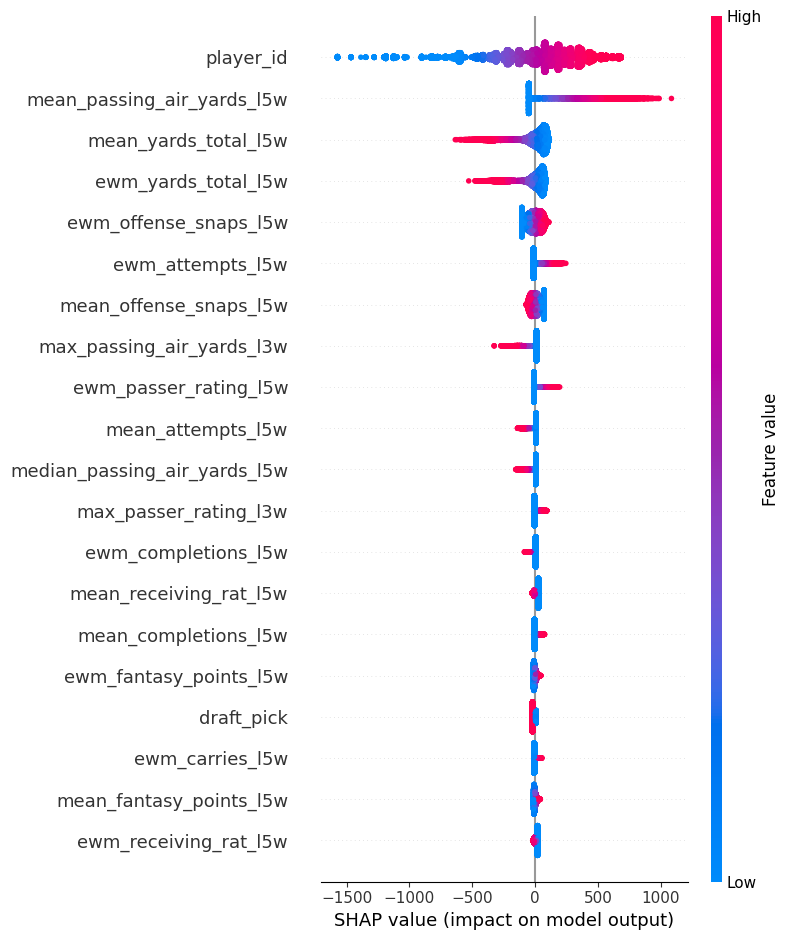

In [19]:
def main():
    # Prepare the data
    df_merged = prepare_features()
    X_train, X_test, y_train, y_test = split_data(df_merged)
    preprocessor = create_preprocessor(df_merged)

    # Define the models and their hyperparameters
    models = {
        'XGBoost': (XGBRegressor(), {
            'model__n_estimators': [100, 500],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.05, 0.1],
            'model__alpha': [0.01, 1, 10],
        }),
        'Linear Regression': (LinearRegression(), {
            'model__fit_intercept': [True, False],
            'model__n_jobs': [1, -1]
        })
    }

    # Run the pipeline for each model
    for model_name, (model, param_grid) in models.items():
        print(f"Performing Grid Search for {model_name}...")
        best_model = optimize_hyperparameters(model, param_grid, X_train, y_train, preprocessor)
        print(f"Evaluating {model_name}...")
        evaluate_models(best_model, X_test, y_test)
        plot_feature_importances(best_model, X_train)

if __name__ == "__main__":
    main()